# Computational Intelligence and Decision Making Lab 2
# Vitalija Serapinaite IFM-1/1

### Dataset:
#### Draper Satellite Image Chronology: https://www.kaggle.com/c/draper-satellite-image-chronology/data

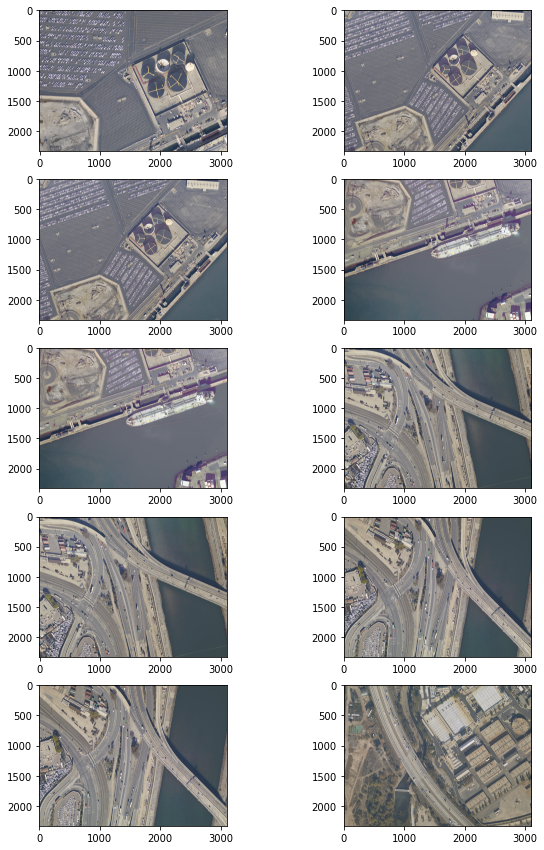

In [13]:
from PIL import Image
import matplotlib.pyplot as plt
import os
import math

image_folder = 'image_data'
images = os.listdir(image_folder)

fig, ax = plt.subplots(5, 2, figsize=(10, 15))

for i in range(5):
    img1 = Image.open(os.path.join(image_folder, images[i]))
    img2 = Image.open(os.path.join(image_folder, images[i + 1]))
    ax[i, 0].imshow(img1)
    ax[i, 1].imshow(img2)


## Functions are in appendices
### Used 30 satellite images. Each image has a size of 3099 x 2329
### Images were splitted to 224 x 224 size blocks and 3900 of such blocks were formed

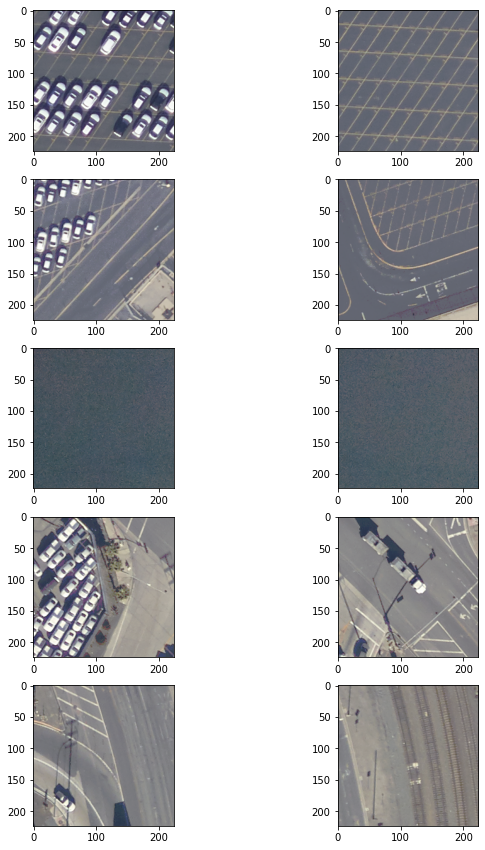

In [22]:
# splitting images to size 224 x 224 
prepare_data('image_data', 'output_img', 224, 224)

### 224 x 224 image blocks
image_folder = 'output_img'
spl_img_fold = os.listdir(image_folder)

fig, ax = plt.subplots(5, 2, figsize=(10, 15))

paths_fun = lambda x: os.path.join(image_folder, x)
get_rand_img = lambda x, i: os.listdir(paths_fun(x))[i]

for i in range(5):
    img1 = Image.open(os.path.join(paths_fun(spl_img_fold[i]), get_rand_img(spl_img_fold[i], i)))
    img2 = Image.open(os.path.join(paths_fun(spl_img_fold[i]), get_rand_img(spl_img_fold[i], i+1)))
    ax[i, 0].imshow(img1)
    ax[i, 1].imshow(img2)

### Features were extracted using VGG16 network feature extractor, last layer of the net was removed and predictions of each image were saved. (Tried to remove more layers but since 3900 images exist, and other layers output high dimension features, faced computer memory issues)

In [24]:
from keras.applications.vgg16 import VGG16

nn = VGG16()
nn.summary()

# Using VGG16 feature extractor for image preprocessing
feature_extraction('output_img', find_embeddings=True)

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

### Since each image had embedding vector with length of 4096, embeddings were normalized and PCA used to extract top 10 components

In [ ]:
# Normalizes embedding values and extracts first 10 PCA components, saves data
feature_extraction('output_img', find_features=True)

## Soft K-means was implemented (code is in appendix). Before using the algorithm we will normalize data and using "expert evaluation" will determine number of possible classes

In [32]:
from sklearn.preprocessing import Normalizer

data = pd.read_csv('final_features.csv')
print(data.head(5))
cluster_data = data.iloc[:, 2:].values

# normalizing data 
norm_data = Normalizer().fit_transform(X=cluster_data)

print(f'\nIn total there are {norm_data.shape[1]} columns and {norm_data.shape[0]} rows in data')


  main_image cropped_img  feature_0  feature_1  feature_2  feature_3  \
0   set107_1       1.png  -0.076410  -0.317165  -0.044274  -0.038914   
1   set107_1      10.png   0.216709  -0.351009   0.035490  -0.009537   
2   set107_1     100.png   0.309059   0.294885   0.006111   0.061337   
3   set107_1     101.png   0.320379   0.297085   0.028532   0.050201   
4   set107_1     102.png   0.188210  -0.003768   0.375871   0.081460   

   feature_4  feature_5  feature_6  feature_7  feature_8  feature_9  
0   0.596988   0.045491   0.006101   0.215490  -0.035565  -0.147913  
1  -0.035561   0.079775  -0.299091   0.145887   0.002985  -0.186884  
2   0.144307   0.173913   0.007145  -0.155917   0.061807   0.023549  
3   0.212023   0.082293  -0.079194  -0.121984  -0.054641   0.012887  
4  -0.055355   0.021042   0.041789  -0.093477   0.189568  -0.127301  

In total there are 10 columns and 3900 rows in data


### Perform “expert evaluation” and make conclusions about possible dataset analysis
### Based on observations, there should be around 5 classes:
1. Sea view
2. Forest
3. Houses
4. Roads
5. Big buildings

In [28]:
# using K-means with 5 clusters
n_clusters = 5
kmeans = KMeansSoftAlg(n_clusters=n_clusters, iterations=20)
clustered_data = kmeans.fit_predict(norm_data)

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Finished iterating


### Will analyze the results now.
### First, will create new dataframe with image names and image clustering results

In [37]:
result_df = data.iloc[:, :2]
col_names = [f'cl_{n}' for n in range(n_clusters)]
result_df[col_names] = clustered_data
result_df['full_path'] = [os.path.join(image_folder, main_f, crp_f) for main_f, crp_f in result_df[['main_image', 'cropped_img']].values]

result_df.head(5)

main_image cropped_img          cl_0          cl_1          cl_2  \
0   set107_1       1.png  9.998806e-01  1.808124e-06  1.127311e-07   
1   set107_1      10.png  8.516859e-03  3.123547e-08  7.617452e-06   
2   set107_1     100.png  2.498128e-09  3.046061e-10  9.999997e-01   
3   set107_1     101.png  1.548760e-09  2.186925e-10  9.999996e-01   
4   set107_1     102.png  1.306681e-06  4.616013e-09  1.135123e-03   

           cl_3          cl_4                    full_path  
0  1.173500e-04  1.285253e-07    output_img\set107_1\1.png  
1  9.074027e-01  8.407278e-02   output_img\set107_1\10.png  
2  7.392587e-08  1.900140e-07  output_img\set107_1\100.png  
3  1.581940e-07  2.397542e-07  output_img\set107_1\101.png  
4  9.988635e-01  5.789982e-08  output_img\set107_1\102.png

### Now will create function that visualizes some images that contain higher scores in selected cluster

In [64]:
def visualize_cluster_images(res_df, cluster_number, thr=0.5, show_n_images=10):
    all_columns = res_df.columns
    cl_column = f'cl_{cluster_number}'
    assert cl_column in all_columns, f'{cluster_number} does not exist'
    filt_res = res_df[res_df[cl_column] >= thr][[cl_column, 'full_path']].reset_index(drop=True)
    img_num = len(filt_res)
    print(f'There are {img_num} images that belong to {cluster_number} cluster and have distance above {thr}')
    show_images = img_num if show_n_images > img_num else show_n_images
    show_images = show_images if not show_images % 2 else show_images - 1 
    assert show_images != 0, f'There are not images that belong to {cluster_number} cluster and have value above {thr}'
    img_rows = show_images // 2
    fig, ax = plt.subplots(img_rows, 2, figsize=(15, 20))
    indexes = random.sample(range(0, len(filt_res)-1), show_images)
    print(f"=============== Cluster {cluster_number} with values above {thr} ============")
    for i in range(img_rows):
        img1 = Image.open(filt_res.loc[indexes[i], "full_path"])
        img2 = Image.open(filt_res.loc[indexes[img_rows + i], "full_path"])
        ax[i, 0].imshow(img1)
        val1 = filt_res.loc[indexes[i], cl_column]
        val2 = filt_res.loc[indexes[img_rows + i], cl_column]
        ax[i, 0].set_title(f"value {round(val1, 3)}")
        ax[i, 1].imshow(img2)
        ax[i, 1].set_title(f"value {round(val2, 3)}")


There are 689 images that belong to 0 cluster and have distance above 0.95
=============== Cluster 0 with values above 0.95 ============


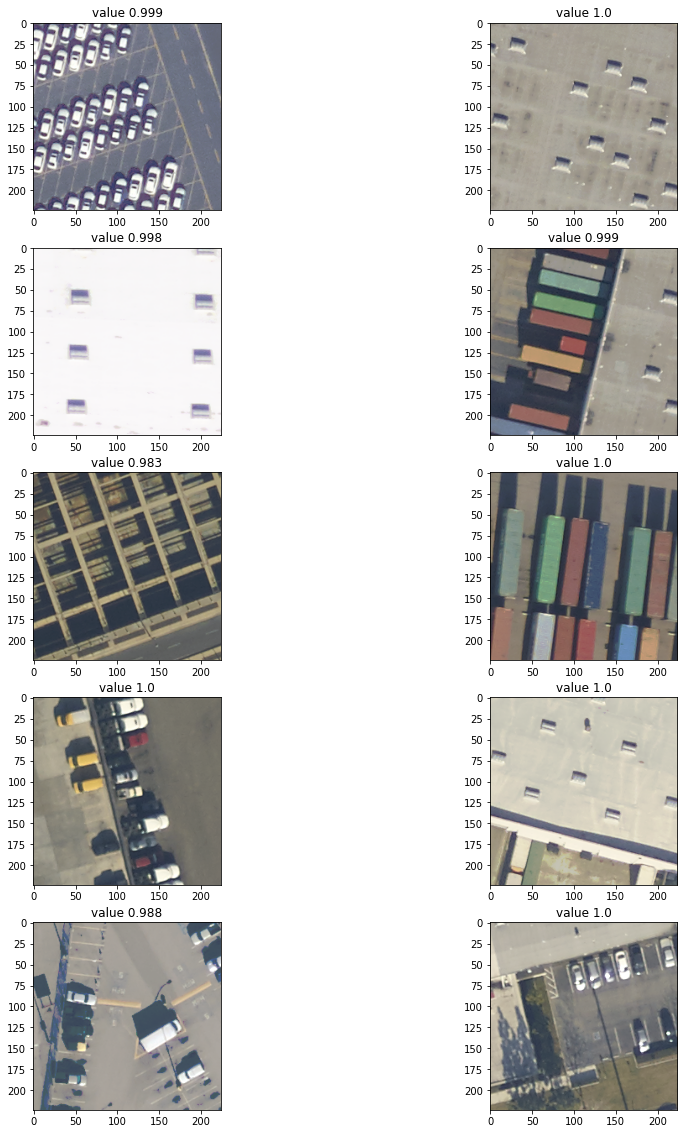

In [76]:
visualize_cluster_images(result_df, 0, thr=0.95)

### It seems 0th cluster contains images that contain different type rectangular objects

There are 854 images that belong to 1 cluster and have distance above 0.95
=============== Cluster 1 with values above 0.95 ============


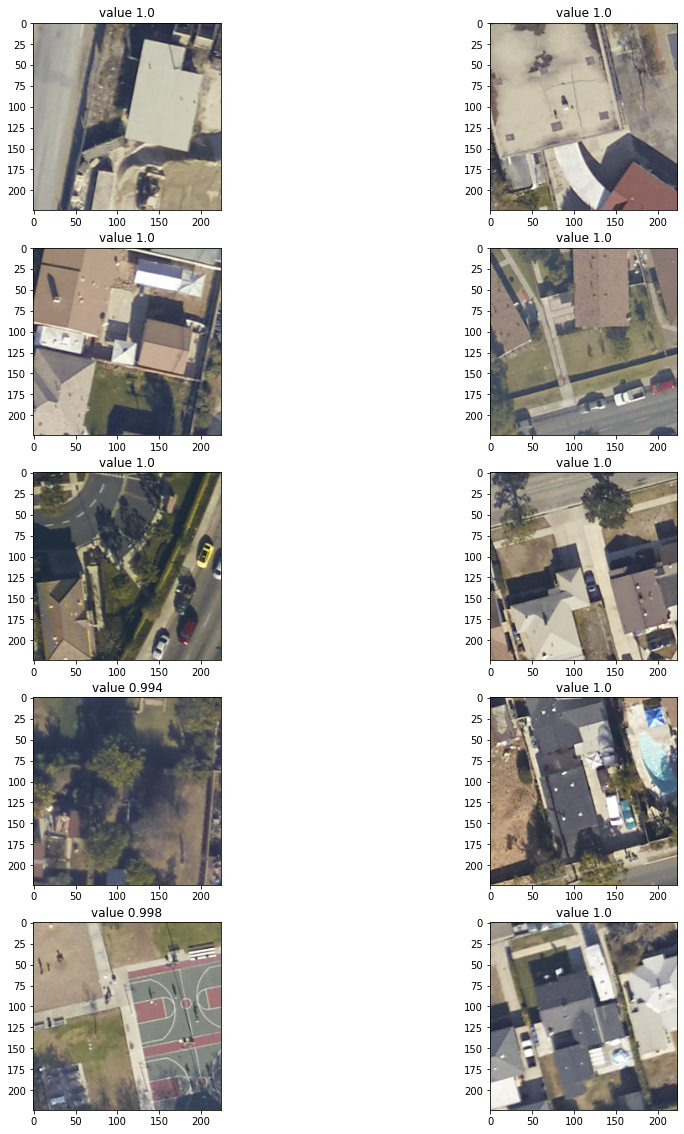

In [74]:
visualize_cluster_images(result_df, 1, thr=0.95)

### 1st cluster contains images that have many different objects in them: houses, roads, cars, trees

There are 507 images that belong to 2 cluster and have distance above 0.95
=============== Cluster 2 with values above 0.95 ============


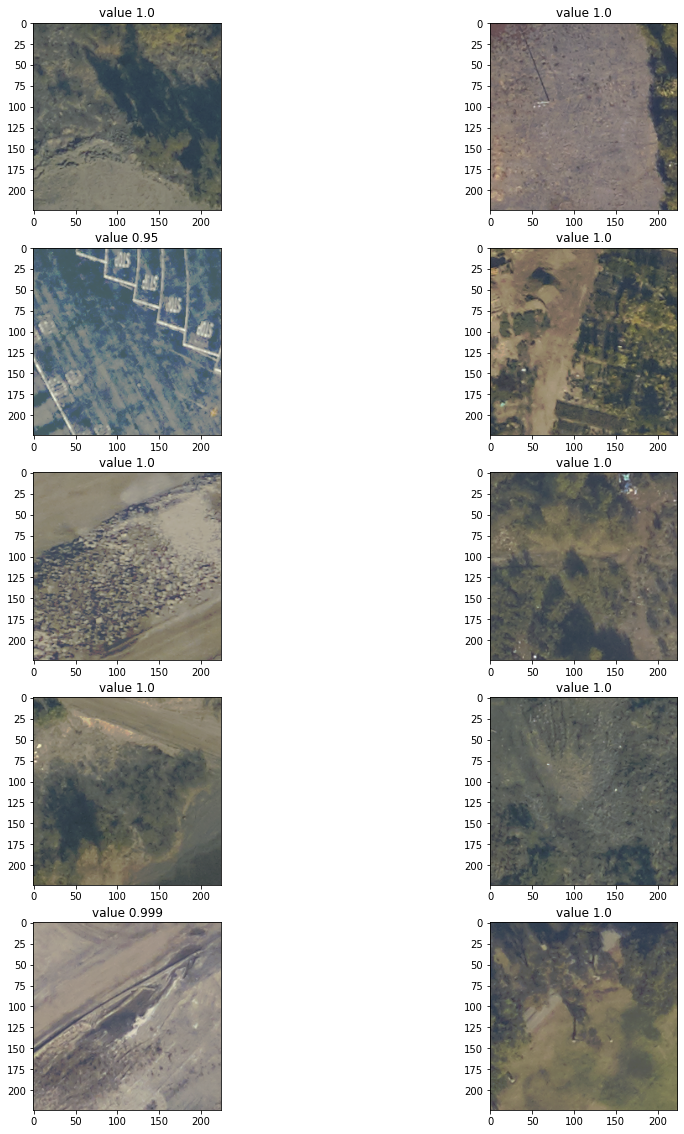

In [77]:
visualize_cluster_images(result_df, 2, thr=0.95)

### 2nd cluster contains images full of nature

There are 669 images that belong to 3 cluster and have distance above 0.95
=============== Cluster 3 with values above 0.95 ============


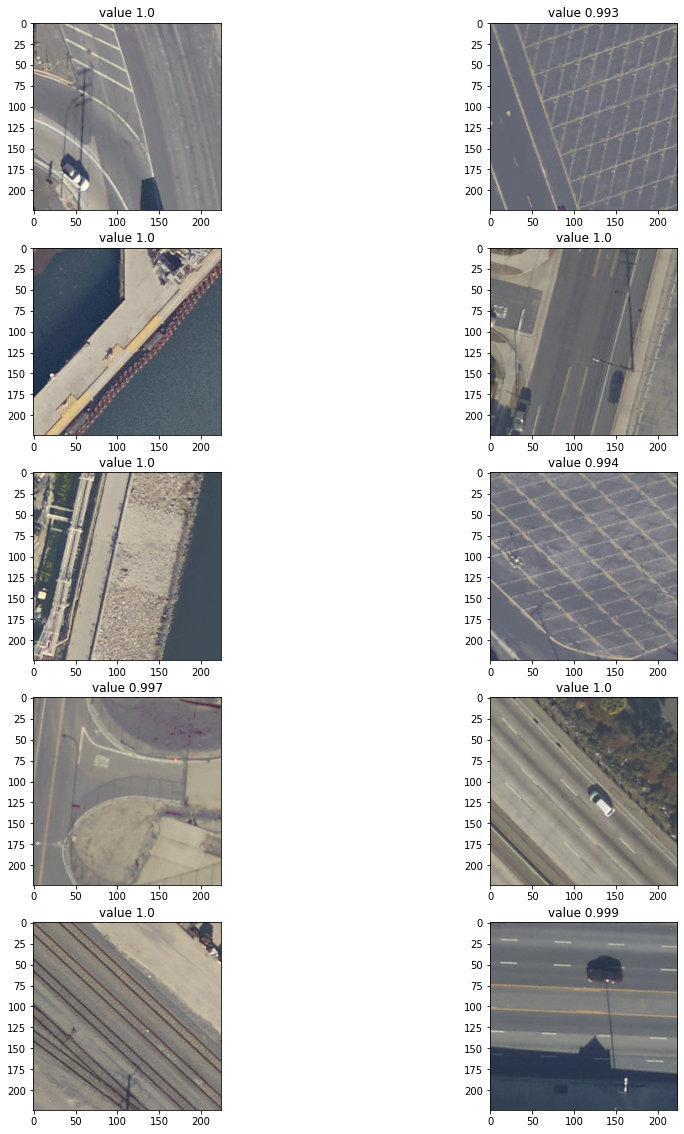

In [82]:
visualize_cluster_images(result_df, 3, thr=0.95)

### It seems 3th cluster contains road images

There are 305 images that belong to 4 cluster and have distance above 0.95
=============== Cluster 4 with values above 0.95 ============


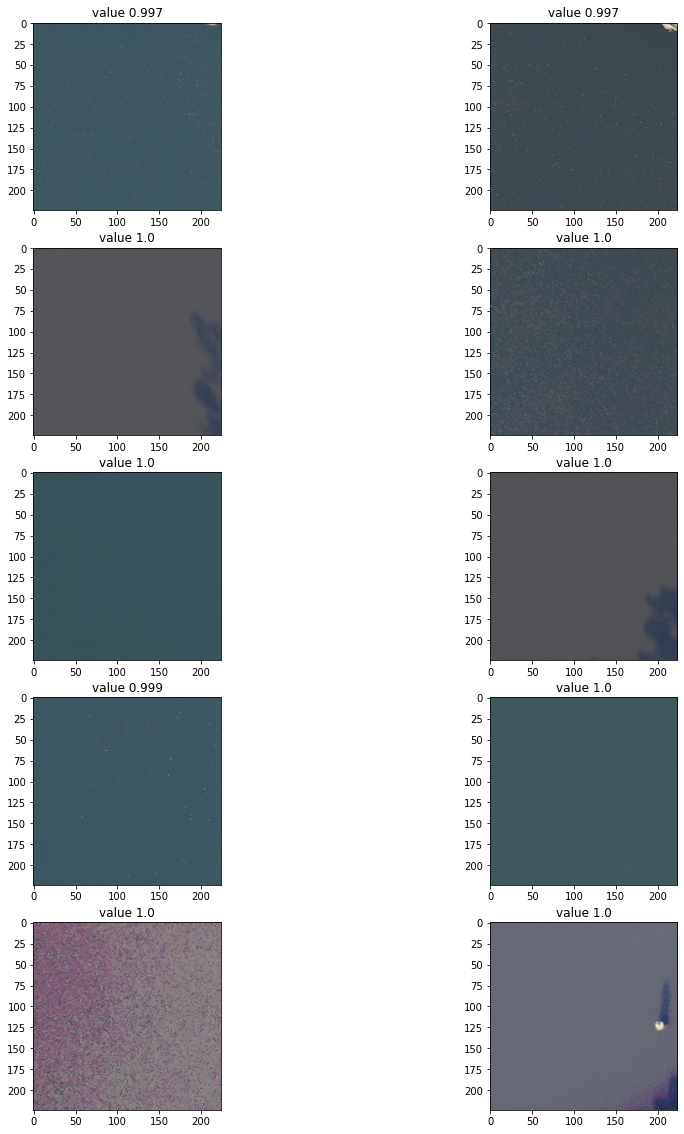

In [80]:
visualize_cluster_images(result_df, 4, thr=0.95)

### 4th cluster contains images that do not have any objects and look like plain background

### In summary, 5 clusters were used for image analysis, each cluster represents:
1. 0th cluster contains images that contain different type rectangular objects
2. 1st cluster contains images that have many different objects in them: houses, roads, cars, trees
3. 2nd cluster contains images full of nature
4. 3th cluster contains road images
5. 4th cluster contains images that do not have any objects and look like plain background

Each cluster could have a class name:
1. Rectangulars
2. Living area
3. Nature background
4. Roads
5. Plain background

# Appendices

## Data preparation:
1. Opens large images and splits them into smaller images 
2. Extracts features using VGG16 feature extractor
3. Normalizes extracted features and takes first 10 PCA components
4. Saves the results in dataframe 

In [14]:
import os
from PIL import Image
import numpy as np
from tensorflow import keras
from keras.applications.vgg16 import VGG16
import tensorflow as tf
from sklearn.decomposition import PCA
from sklearn.preprocessing import Normalizer
import pandas as pd


def open_images(image_folder):
    images_dict = {}
    for img in os.listdir(image_folder):
        im = Image.open(os.path.join(image_folder, img))
        images_dict[img.split('.')[0]] = np.array(im)
    return images_dict


def split_image(image, folder_name, width, height):
    shape = image.shape
    ind = 0
    for i in range(0, shape[0], height):
        for j in range(0, shape[1], width):
            crop_img = image[i:i + height, j:j + width]
            ind += 1
            if crop_img.shape[0] == height and crop_img.shape[1] == width:
                im = Image.fromarray(crop_img)
                im.save(os.path.join(folder_name, f'{ind}.png'))       


def split_all_images(images_dict, save_img_main_folder='output_img', width=150, height=150):
    if not os.path.isdir(save_img_main_folder):
            os.mkdir(save_img_main_folder)

    for k, v in images_dict.items():
        pth = os.path.join(save_img_main_folder, k)
        if os.path.isdir(pth):
            continue
        os.mkdir(pth)
        split_image(v, pth, width, height)


def load_model(remove_n_layers=1):

    def remove_last_layer(model, remove_n_layers):
        new_model = tf.keras.models.Sequential()
        for layer in model.layers[:-remove_n_layers]:
            new_model.add(layer)
        return new_model
    
    model = VGG16(weights='imagenet')
    mdl = remove_last_layer(model, remove_n_layers)
    return mdl


def load_all_images(save_img_main_folder='output_img'):
    cropped_images_dict = {}
    for image_folder in os.listdir(save_img_main_folder):
        img_dict = {}
        for img in os.listdir(os.path.join(save_img_main_folder, image_folder)):
            try:
                loaded_img = np.array(Image.open(os.path.join(save_img_main_folder, image_folder, img)))
                img_dict[img] = loaded_img
            except:
                print('Weirdly saved image, cannot open')
        cropped_images_dict[image_folder] = img_dict
    return cropped_images_dict


def save_features(model, images, image_dict, output_name='embeddings.txt'):
    predictions = []
    batch_size = 5
    
    for i in range(0, len(images), batch_size):
        img_batch = images[i:i+batch_size]
        prediction = model.predict(np.array(img_batch))
        img_shape = prediction.shape
        total_features = img_shape[1]# * img_shape[2] * img_shape[3]
        reshaped_predictions = prediction.reshape(img_shape[0], total_features)
        predictions.extend(reshaped_predictions)
    main_img_name_li = []
    cropped_img_name_li = []
    for k, v in image_dict.items():
        main_img_name_li += [k] * len(image_dict[k])
        cropped_img_name_li.extend(list(image_dict[k].keys()))

    with open(output_name, 'w') as f:
        for main_name, crop_img_name, row in zip(main_img_name_li, cropped_img_name_li, predictions):
            something = list_to_string(row)
            f.write(main_name+';')
            f.write(crop_img_name+';')
            f.write(something)


def list_to_string(li):
    string = ''
    for el in li:
        string += f'{el};'
    string += '/n'
    return string


def read_embedding_file(file_name):
    initial_li = []
    embedding_dict = {}
    with open(file_name, 'r') as f:
        text = f.readlines()
        lines = text[0].split('/n')
        for line in lines:
            if not len(line):
                break
            items = line.split(';')
            img_name = items[0]
            cropped_img_name = items[1]
            initial_li.append([img_name, cropped_img_name])
            embeddings = [float(it) for it in items[2:] if it!= '' and it != ' ' and it != '.']
            embedding_dict[f'{img_name}_{cropped_img_name}'] = embeddings
    df = pd.DataFrame(initial_li, columns=['main_image', 'cropped_img'])
    return df, embedding_dict
    

def extract_features(file_name, n_components, random_state=42):
    df, embedding_dict = read_embedding_file(file_name)
    norm = Normalizer()
    embeddings = np.array(list(embedding_dict.values()))
    normalized_predictions = norm.fit_transform(embeddings)
    pca = PCA(n_components=n_components, random_state=random_state)
    prediction_features = pca.fit_transform(normalized_predictions)
    return prediction_features, df


def prepare_data(image_folder, save_img_main_folder, width, height):
    images_dict = open_images(image_folder)
    split_all_images(images_dict, save_img_main_folder, width, height)


def convert_images_to_list(image_dict):
    li = []
    for k in image_dict.keys():
        li.extend(list(image_dict[k].values()))
    return li


def create_feature_df(old_df, features):
    df = old_df[['main_image', 'cropped_img']]
    sh = np.array(features).shape
    feature_names = [f'feature_{i}' for i in range(sh[1])]
    df[feature_names] = features
    return df


def feature_extraction(save_img_main_folder, remove_n_layers=1, find_embeddings=False, 
                       find_features=False):
    output_name = 'embeddings.txt'
    if find_embeddings:
        loaded_images_dict = load_all_images(save_img_main_folder)
        model = load_model(remove_n_layers)
        img_li = convert_images_to_list(loaded_images_dict)
        save_features(model, img_li, loaded_images_dict, output_name)
    if find_features:
        features, init_df = extract_features(output_name, n_components=10, random_state=42)
        df = create_feature_df(init_df, features)
        df.to_csv('final_features.csv', index=False, header=True)


In [26]:
import numpy as np
import random
import logging
import pandas as pd
from sklearn.metrics import silhouette_score

class KMeansSoftAlg:

    def __init__(self, n_clusters, random_state=42, scaling_param=0.2, iterations=20, epsilon=0.0000001):
        random.seed(random_state)
        self.n_clusters = n_clusters
        self.iterations = iterations
        self.scaling_param = scaling_param
        self.epsilon = epsilon

    def fit(self, X):
        self.create_clusters(X)

    def create_clusters(self, X):
        data_shape = X.shape
        self.rows = data_shape[0]
        self.columns = data_shape[1]
        self.point_weights = np.zeros((self.rows, self.n_clusters))
        self.find_min_max_range(X)
        self.initialize_cluster_centers()
        self.iterate(X)


    def fit_predict(self, X):
        self.create_clusters(X)
        return self.point_weights

    def predict(self, new_x):
        point_weights = []
        row = new_x.shape[0]
        for i in range(row):
            point = new_x[i, :]
            weights = self.get_point_weights(point)
            point_weights.append(weights)
        return point_weights

    def euclidean_distance(self, point1, point2):
        dist = np.linalg.norm(point1 - point2)
        return dist

    def get_point_weights(self, point):
        soft_weights = []
        for k in range(self.n_clusters):
            cl_center = self.centers[k]
            dist = self.euclidean_distance(point, cl_center)
            affinity = np.exp(-(dist**2)/(2*(self.scaling_param**2)))
            soft_weights.append(affinity)
        return np.array(soft_weights) / np.sum(soft_weights)

    def get_all_weights(self, X):
        for i in range(self.rows):
            point = X[i, :]
            weights = self.get_point_weights(point)
            self.point_weights[i, :] = weights

    def adjust_centers(self, X):
        self.prev_centers = self.centers.copy()
        for i in range(self.n_clusters):
            arr = np.zeros(self.columns)
            arr_denominator = np.zeros(self.columns)
            for j in range(self.rows):
                cluster_weights = self.point_weights[j, i]
                arr += np.array(cluster_weights * X[j, :])
                arr_denominator += np.array(cluster_weights)
            self.centers[i] = arr / arr_denominator

    def iterate(self, X):
        for i in range(self.iterations):
            print(f'Iteration: {i}')
            self.get_all_weights(X)
            self.adjust_centers(X)
            if self.epsilon > np.linalg.norm(np.array(self.centers) - np.array(self.prev_centers)):
                print("K-means converged")
                break
        print("Finished iterating")


    def initialize_cluster_centers(self):
        # initializes point between min and max
        centers = []
        for cl in range(self.n_clusters):
            center_point = []
            for i in range(self.columns):
                min_val = self.column_min_values[i]
                max_val = self.column_max_values[i]

                if int(min_val) == min_val and int(max_val) == max_val:
                    val = random.randint(min_val, max_val)
                else:
                    val = random.uniform(min_val, max_val)

                center_point.append(val)
            centers.append(center_point)
        self.centers = centers
        self.prev_centers = centers


    def find_min_max_range(self, X):
        column_min_values, column_max_values = [], []
        for i in range(self.columns):
            column_data = X[:, i]
            min_val = min(column_data)
            max_val = max(column_data)
            column_min_values.append(min_val)
            column_max_values.append(max_val)

        self.column_min_values = column_min_values
        self.column_max_values = column_max_values
